# Model details
***Used base model***: bert-base-uncased
***Used dataset***: SQuAD
***Batch size***: 4
***Datasets***: Train and val combined into train
***Loss function***: Hugging face default
***Attempted train epochs***: 3
***Initial learning rate***: 2e-5
***End learning rate***: 0
***Additional info***: Makes use of stride mechanism

In [19]:
from transformers import (
    AutoTokenizer,
    TFAutoModelForQuestionAnswering,
    DefaultDataCollator,
    create_optimizer,
)
import tensorflow as tf
from question_answering.constants import constants
from question_answering.utils import core_qa_utils, extractive_qa_utils
from question_answering.paths import extractive_qa_paths
import ipynbname
from question_answering.keras_callbacks.time_measure_callback import TimeMeasureCallback
from tqdm.auto import tqdm
import collections
import evaluate
import numpy as np

# Data loading, analyzing and preprocessing

In [2]:
# Load SQuAD dataset
df_train, df_val, df_test = core_qa_utils.load_train_val_test_datasets(
    extractive_qa_paths.squad_dataset_dir
)

train_dataset, val_dataset, test_dataset = core_qa_utils.convert_dataframes_to_datasets(
    [df_train, df_val, df_test]
)

train_dataset = core_qa_utils.concatenate_hf_datasets(
    [train_dataset, val_dataset]
)

In [3]:
# Specify the base model and load its tokenizer
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [4]:
# Function for preprocessing the dataset
max_length = 384
stride = 128


def preprocess_dataset(dataset):
    questions = [q.strip() for q in dataset["question"]]
    contexts = [c.strip() for c in dataset["context"]]

    inputs = tokenizer(
        questions,
        contexts,
        max_length=max_length,
        padding="max_length",
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
    )

    offset_mapping = inputs["offset_mapping"]
    sample_map = inputs["overflow_to_sample_mapping"]

    answer_start_indices = dataset["answer_start"]
    answer_texts = dataset["answer_text"]

    # For stride mechanism we need to manually keep the columns
    # ['index', 'id', 'context', 'question', 'answer_text', 'answer_start']
    ids_column = []
    contexts_column = []
    questions_column = []
    answer_texts_column = []
    answer_starts_column = []

    start_positions = []
    end_positions = []

    for index, offset in enumerate(offset_mapping):
        sample_idx = sample_map[index]
        start_char = answer_start_indices[sample_idx]
        end_char = start_char + len(answer_texts[sample_idx])
        sequence_ids = inputs.sequence_ids(index)

        # Find the start and end token indices of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
            answer_texts_column.append(None)
            answer_starts_column.append(None)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)
            answer_texts_column.append(dataset["answer_text"][sample_idx])
            answer_starts_column.append(dataset["answer_start"][sample_idx])

        ids_column.append(dataset["id"][sample_idx])
        contexts_column.append(dataset["context"][sample_idx])
        questions_column.append(dataset["question"][sample_idx])

    inputs["id"] = ids_column
    inputs["context"] = contexts_column
    inputs["question"] = questions_column
    inputs["answer_text"] = answer_texts_column
    inputs["answer_start"] = answer_starts_column
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [5]:
# Tokenize the dataset
tokenized_train_dataset = train_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=["index"],
)
tokenized_test_dataset = test_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=["index"],
)

Map:   0%|          | 0/83440 [00:00<?, ? examples/s]

Map:   0%|          | 0/14725 [00:00<?, ? examples/s]

In [6]:
# How many samples were added
print(
    "Original train: ",
    len(train_dataset),
    " Original test: ",
    len(test_dataset),
)
print(
    "Tokenized train: ",
    len(tokenized_train_dataset),
    " Tokenized test: ",
    len(tokenized_test_dataset),
)

Original train:  83440  Original test:  14725
Tokenized train:  84395  Tokenized test:  14909


In [7]:
# Check that all tokenized samples have max length of tokens
print(
    f"All tokenized train dataset entries have {max_length} tokens: ",
    all(
        [
            len(input_ids) == max_length
            for input_ids in tokenized_train_dataset["input_ids"]
        ]
    ),
)
print(
    f"All tokenized test dataset entries have {max_length} tokens: ",
    all(
        [
            len(input_ids) == max_length
            for input_ids in tokenized_test_dataset["input_ids"]
        ]
    ),
)

All tokenized train dataset entries have 384 tokens:  True
All tokenized test dataset entries have 384 tokens:  True


In [8]:
# Model parameters
full_model_name = "-".join(ipynbname.name().split("_"))

# Checkpoints
checkpoint_filename_template = constants.checkpoint_filename_template
checkpoints_path = (
        extractive_qa_paths.training_checkpoints_dir
        / full_model_name
        / checkpoint_filename_template
)

# Saved models
saved_models_path = extractive_qa_paths.saved_models_dir / full_model_name

# Evaluation
model_evaluation_dir = extractive_qa_paths.model_evaluation_dir / full_model_name
figures_dir = model_evaluation_dir / constants.figures_dir_name

# Hyperparameters
batch_size = 4
train_epochs = 3
initial_learning_rate = 2e-5
end_learning_rate = 0

In [9]:
# Dataset preparation
data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_train_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)
tf_test_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_test_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)

# Model training

In [10]:
# Load model for fine-tuning
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

All PyTorch model weights were used when initializing TFBertForQuestionAnswering.

Some weights or buffers of the TF 2.0 model TFBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoints_path, verbose=1, save_weights_only=True
)
time_measure_cb = TimeMeasureCallback()

callbacks = [checkpoint_cb, time_measure_cb]

In [12]:
# Compile
num_train_steps = len(tf_train_dataset) * train_epochs
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Compile
model.compile(optimizer=optimizer)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


In [13]:
model.summary()

Model: "tf_bert_for_question_answering"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 qa_outputs (Dense)          multiple                  1538      
                                                                 
Total params: 108,893,186
Trainable params: 108,893,186
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Fit the model on the new data
history = model.fit(
    tf_train_dataset,
    epochs=train_epochs,
    callbacks=callbacks,
)

Epoch 1/3
21099/21099 [==============================] - ETA: 0s - loss: 1.2453
Epoch 1: saving model to D:\dev\projects\question-answering\extractive-qa\training-checkpoints\squad-bert-uncased-5\cp-01.ckpt
21099/21099 [==============================] - 3344s 158ms/step - loss: 1.2453
Epoch 2/3
21099/21099 [==============================] - ETA: 0s - loss: 0.7003
Epoch 2: saving model to D:\dev\projects\question-answering\extractive-qa\training-checkpoints\squad-bert-uncased-5\cp-02.ckpt
21099/21099 [==============================] - 3309s 157ms/step - loss: 0.7003
Epoch 3/3
21099/21099 [==============================] - ETA: 0s - loss: 0.4371
Epoch 3: saving model to D:\dev\projects\question-answering\extractive-qa\training-checkpoints\squad-bert-uncased-5\cp-03.ckpt
21099/21099 [==============================] - 3286s 156ms/step - loss: 0.4371


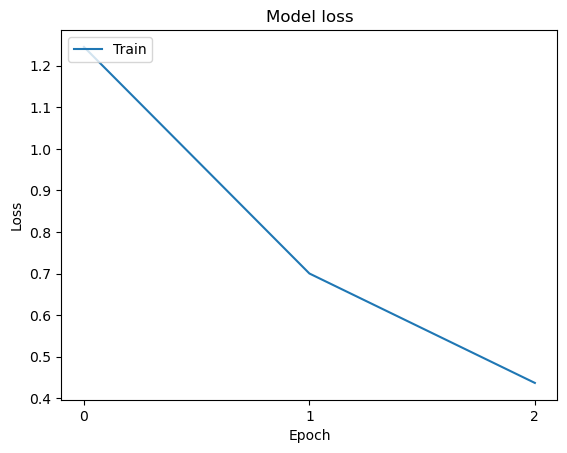

In [15]:
# Plot training figures
core_qa_utils.plot_and_save_fig_from_history(
    history.history,
    attributes=["loss"],
    title="Model loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_loss.png",
)

In [16]:
model.evaluate(tf_test_dataset)

3728/3728 [==============================] - 230s 61ms/step - loss: 1.0804


1.0804094076156616

In [22]:
epoch_4_model_preds = model.predict(tf_test_dataset)

3728/3728 [==============================] - 225s 60ms/step


In [24]:
# Save best model's weights
extractive_qa_utils.save_model(model, model_name=full_model_name)

# Evaluation of the model on its test dataset

In [25]:
# Load best model
loaded_model = extractive_qa_utils.load_model(
    model_checkpoint, model_name=full_model_name
)
loaded_model.compile(optimizer=optimizer)

All PyTorch model weights were used when initializing TFBertForQuestionAnswering.

Some weights or buffers of the TF 2.0 model TFBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Get predictions from the best model
loaded_model_evaluation = loaded_model.evaluate(tf_test_dataset)

3728/3728 [==============================] - 167s 44ms/step - loss: 1.0806


In [27]:
loaded_model_preds = loaded_model.predict(tf_test_dataset)

3728/3728 [==============================] - 164s 43ms/step


In [21]:
# Convert predictions to start and end position indices
start_preds = extractive_qa_utils.get_class_preds(
    predictions=loaded_model_preds, output_key="start_logits"
)
end_preds = extractive_qa_utils.get_class_preds(
    predictions=loaded_model_preds, output_key="end_logits"
)

In [22]:
# Convert predictions to actual texts and mark samples as correctly predicted
model_predictions = tokenized_test_dataset.map(
    lambda row, idx: extractive_qa_utils.extract_prediction_tokens(
        row, start_pred=start_preds[idx], end_pred=end_preds[idx]
    ),
    with_indices=True,
)

model_predictions = model_predictions.map(
    lambda row: extractive_qa_utils.decode_answer_tokens(row, tokenizer)
)

model_predictions = model_predictions.map(
    lambda row: extractive_qa_utils.mark_correct_predictions(row)
)

Map:   0%|          | 0/14909 [00:00<?, ? examples/s]

Map:   0%|          | 0/14909 [00:00<?, ? examples/s]

Map:   0%|          | 0/14909 [00:00<?, ? examples/s]

In [23]:
# Calculate start positions classification metrics
(
    start_precision,
    start_recall,
    start_f1,
) = extractive_qa_utils.get_classification_evaluation_metrics(
    class_actual=tokenized_test_dataset["start_positions"],
    class_preds=start_preds,
    average="micro",
)

print(f"Start positions precision score: ", start_precision)
print(f"Start positions recall score: ", start_recall)
print(f"Start positions F1 score: ", start_f1)

Start positions precision score:  0.6922664162586357
Start positions recall score:  0.6922664162586357
Start positions F1 score:  0.6922664162586357


In [24]:
# Calculate end positions classification metrics
(
    end_precision,
    end_recall,
    end_f1,
) = extractive_qa_utils.get_classification_evaluation_metrics(
    class_actual=tokenized_test_dataset["end_positions"],
    class_preds=end_preds,
    average="micro",
)

print(f"End positions precision score: ", end_precision)
print(f"End positions recall score: ", end_recall)
print(f"End positions F1 score: ", end_f1)

End positions precision score:  0.7293581058421088
End positions recall score:  0.7293581058421088
End positions F1 score:  0.7293581058421088


In [25]:
# General accuracy of predictions
(
    general_accuracy,
    general_lowercase_accuracy,
) = extractive_qa_utils.calculate_general_accuracy(
    actual=model_predictions["answer_text"],
    predicted=model_predictions["predicted_answer_text"],
)

print(f"General accuracy: {general_accuracy}")
print(f"General lowercase accuracy: {general_lowercase_accuracy}")

General accuracy: 0.24669662619894023
General lowercase accuracy: 0.5280032195318264


In [26]:
# We can calculate exact match only on samples that have textual answer and have predicted so
textual_model_predictions = model_predictions.filter(
    lambda sample: sample["predicted_answer_text"] is not None
                   and sample["answer_text"] is not None
)

Filter:   0%|          | 0/14909 [00:00<?, ? examples/s]

In [27]:
# Calculate exact match for the test set
(
    exact_match_original,
    exact_match_lowercase,
    exact_match_lowercase_no_punctuation,
) = extractive_qa_utils.calculate_pure_exact_match(
    actual=textual_model_predictions["answer_text"],
    predicted=textual_model_predictions["predicted_answer_text"],
)

print(f"Exact match for original dataset: ", exact_match_original["exact_match"])
print(f"Exact match case insensitive: ", exact_match_lowercase["exact_match"])
print(
    f"Exact match case insensitive and punctuation ignoring: ",
    exact_match_lowercase_no_punctuation["exact_match"],
)

Exact match for original dataset:  0.24244687351483468
Exact match case insensitive:  0.5271912553465952
Exact match case insensitive and punctuation ignoring:  0.5364247403082355


In [28]:
# Calculate squad exact match for the test set
squad_exact_match_results = extractive_qa_utils.calculate_squad_exact_match(
    textual_model_predictions
)

print(f"SQuAD exact match: ", squad_exact_match_results["exact_match"])
print(f"SQuAD F1: ", squad_exact_match_results["f1"])

SQuAD exact match:  59.08751442732025
SQuAD F1:  73.2748538346897


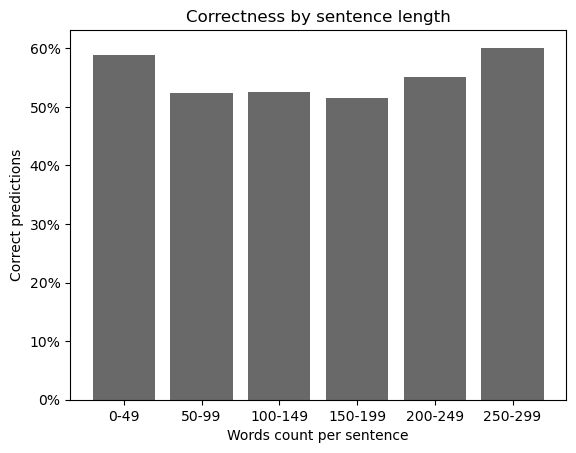

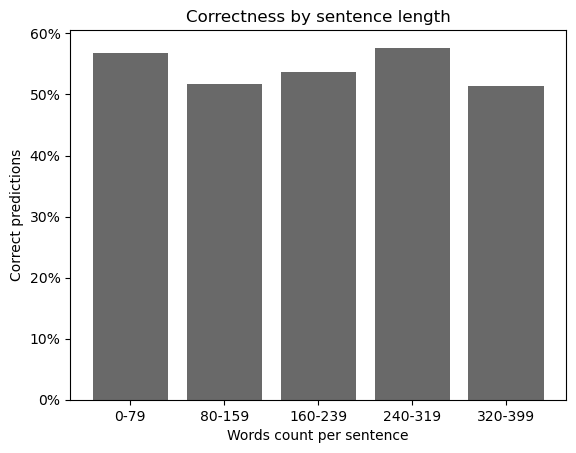

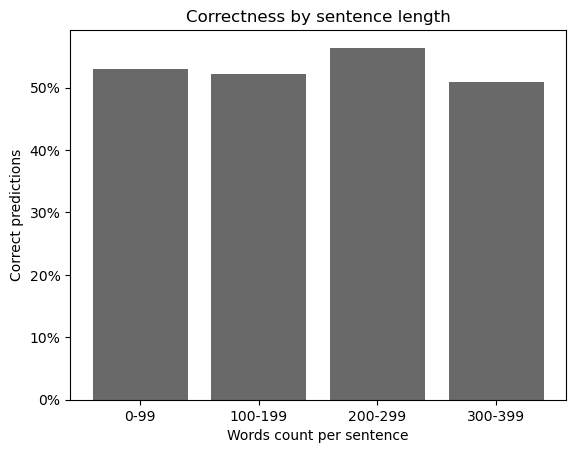

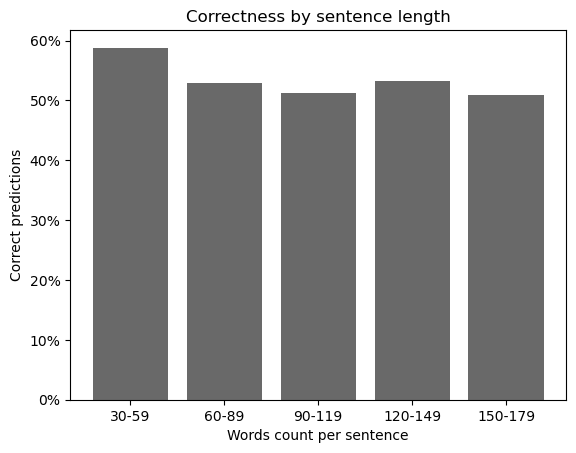

In [29]:
# Plot correctness of the model by sentence length
core_qa_utils.plot_correct_predictions_by_sentence_length(
    sentences=model_predictions["context"],
    correctly_predicted=model_predictions["correctly_predicted_lowercase"],
    figure_path=figures_dir
                / f"{full_model_name}_context_sentence_lengths_to_correct_preds_0_300_50.png",
    figure_title="Correctness by sentence length",
    divider=50,
    min_threshold=0,
    max_threshold=300,
)

core_qa_utils.plot_correct_predictions_by_sentence_length(
    sentences=model_predictions["context"],
    correctly_predicted=model_predictions["correctly_predicted_lowercase"],
    figure_path=figures_dir
                / f"{full_model_name}_context_sentence_lengths_to_correct_preds_0_400_80.png",
    figure_title="Correctness by sentence length",
    divider=80,
    min_threshold=0,
    max_threshold=400,
)

core_qa_utils.plot_correct_predictions_by_sentence_length(
    sentences=model_predictions["context"],
    correctly_predicted=model_predictions["correctly_predicted_lowercase"],
    figure_path=figures_dir
                / f"{full_model_name}_context_sentence_lengths_to_correct_preds_0_400_100.png",
    figure_title="Correctness by sentence length",
    divider=100,
    min_threshold=0,
    max_threshold=400,
)

core_qa_utils.plot_correct_predictions_by_sentence_length(
    sentences=model_predictions["context"],
    correctly_predicted=model_predictions["correctly_predicted_lowercase"],
    figure_path=figures_dir
                / f"{full_model_name}_context_sentence_lengths_to_correct_preds_30_180_30.png",
    figure_title="Correctness by sentence length",
    divider=30,
    min_threshold=30,
    max_threshold=180,
)

In [31]:
# Save all relevant training and evaluation metrics to a json file.
evaluation_data = {
    "training": {
        "metrics": history.history,
        "attempted_epochs": train_epochs,
        "best_epoch": best_epoch,
        "training_time": time_measure_cb.total_training_time(),
        "gpu": core_qa_utils.get_gpu_name(),
    },
    "test_set": {
        "loss": loaded_model_evaluation,
        "general_accuracy": general_accuracy,
        "general_lowercase_accuracy": general_lowercase_accuracy,
        "start_positions": {
            "precision": start_precision,
            "recall": start_recall,
            "f1": start_f1,
        },
        "end_positions": {
            "precision": end_precision,
            "recall": end_recall,
            "f1": end_f1,
        },
        "exact_match": {
            "case_sensitive": exact_match_original["exact_match"],
            "case_insensitive": exact_match_lowercase["exact_match"],
            "case_insensitive_and_no_punctuation": exact_match_lowercase["exact_match"],
            "squad": squad_exact_match_results["exact_match"],
            "squad_f1": squad_exact_match_results["f1"],
        },
    },
}

core_qa_utils.save_dict_as_json(
    evaluation_data, dir_path=model_evaluation_dir, filename="evaluation_data.json"
)

In [32]:
# Remove unnecessary columns
model_predictions = model_predictions.remove_columns(
    [
        "input_ids",
        "token_type_ids",
        "attention_mask",
        "prediction_tokens",
        "answer_start",
        "offset_mapping",
    ]
)

In [33]:
# Check if there exist any predictions where start position is greater than end positions
start_after_end_indices = []

for index, start_pred in enumerate(start_preds):
    end_pred = end_preds[index]
    model_prediction = model_predictions[index]
    if start_pred > end_pred:
        start_after_end_indices.append(index)
        print("Correct answer: ", model_prediction["answer_text"])
        print("Predicted answer: ", model_prediction["predicted_answer_text"])
        print(
            "Correct start: ",
            model_prediction["start_positions"],
            " Correct end: ",
            model_prediction["end_positions"],
        )
        print(
            "Predicted start: ",
            start_pred,
            " Predicted end: ",
            end_pred,
        )
        print("------------")

Correct answer:  "always crescendo to a high note"
Predicted answer:  
Correct start:  117  Correct end:  127
Predicted start:  118  Predicted end:  108
------------
Correct answer:  genetic researchers who have done extensive population mapping studies
Predicted answer:  
Correct start:  40  Correct end:  48
Predicted start:  63  Predicted end:  20
------------
Correct answer:  that guesses based on face photos perform better than chance
Predicted answer:  
Correct start:  74  Correct end:  84
Predicted start:  95  Predicted end:  84
------------
Correct answer:  The Purple
Predicted answer:  
Correct start:  67  Correct end:  68
Predicted start:  74  Predicted end:  68
------------
Correct answer:  The Copyright Act
Predicted answer:  
Correct start:  130  Correct end:  132
Predicted start:  158  Predicted end:  132
------------
Correct answer:  Creon, the current King of Thebes
Predicted answer:  
Correct start:  65  Correct end:  73
Predicted start:  65  Predicted end:  61
--------

In [34]:
# Save test dataset evaluation
final_evaluation_df = model_predictions.to_pandas()
final_evaluation_df.to_csv(
    model_evaluation_dir / "test_set_evaluation.csv", index=True, index_label="index"
)

# Evaluate using their evaluation technique

In [28]:
n_best = 20
max_answer_length = 30


def compute_metrics(start_logits, end_logits, features, examples):
    metric = evaluate.load("squad")

    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1: -n_best - 1: -1].tolist()
            end_indexes = np.argsort(end_logit)[-1: -n_best - 1: -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                            end_index < start_index
                            or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[
                                offsets[start_index][0]: offsets[end_index][1]
                                ],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [
        {"id": ex["id"], "answers": {
            "text": [ex["answer_text"]],
            "answer_start": [ex["answer_start"]]
        }} for ex in examples
    ]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [29]:
compute_metrics(
    loaded_model_preds['start_logits'],
    loaded_model_preds['end_logits'],
    tokenized_test_dataset,
    test_dataset
)

  0%|          | 0/14725 [00:00<?, ?it/s]

{'exact_match': 68.38709677419355, 'f1': 81.72219599339385}

# Evaluation of model trained on SQuAD on COVID-19 dataset

In [24]:
# Load COVID-19 dataset
med_df_train, med_df_val, med_df_test = core_qa_utils.load_train_val_test_datasets(
    extractive_qa_paths.medical_dataset_dir
)

med_df_train = med_df_train.drop("is_impossible", axis="columns")
med_df_val = med_df_val.drop("is_impossible", axis="columns")
med_df_test = med_df_test.drop("is_impossible", axis="columns")

(
    med_train_dataset,
    med_val_dataset,
    med_test_dataset,
) = core_qa_utils.convert_dataframes_to_datasets(
    [med_df_train, med_df_val, med_df_test]
)

med_all_dataset = core_qa_utils.concatenate_hf_datasets(
    [med_train_dataset, med_val_dataset, med_test_dataset]
)

In [25]:
# Tokenize the medical dataset
tokenized_test_med_dataset = med_test_dataset.map(
    preprocess_dataset, batched=True, remove_columns=["index"]
)

tokenized_med_dataset = med_all_dataset.map(
    preprocess_dataset, batched=True, remove_columns=["index"]
)

Map:   0%|          | 0/303 [00:00<?, ? examples/s]

Map:   0%|          | 0/2019 [00:00<?, ? examples/s]

In [26]:
# How many samples were added to the medical dataset?
print("Original test med: ", len(med_test_dataset))
print("After striding test med: ", len(tokenized_test_med_dataset))

print("------------------------")

print("Original total med: ", len(med_all_dataset))
print("After striding med: ", len(tokenized_med_dataset))

Original test med:  303
After striding test med:  9718
------------------------
Original total med:  2019
After striding med:  62073


Evaluating the model on this set in this way is pointless. It is all 0. It's nearly impossible for the model to get the start and end position right. One should implement the preprocessing of spans of texts nearby the answer from medical set. 

In [27]:
tf_test_med_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_test_med_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)

tf_med_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_med_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)

In [28]:
# Get predictions from the best model pm the medical dataset
med_loaded_model_evaluation = loaded_model.evaluate(tf_test_med_dataset)

2430/2430 [==============================] - 109s 45ms/step - loss: 0.8632 - end_logits_loss: 0.4412 - start_logits_loss: 0.4220 - end_logits_accuracy: 0.9010 - start_logits_accuracy: 0.9074


In [29]:
med_loaded_model_preds = loaded_model.predict(tf_test_med_dataset)

2430/2430 [==============================] - 105s 43ms/step


In [31]:
# Convert predictions to start and end position indices
med_start_preds = extractive_qa_utils.get_class_preds(
    predictions=med_loaded_model_preds, output_key="start_logits"
)
med_end_preds = extractive_qa_utils.get_class_preds(
    predictions=med_loaded_model_preds, output_key="end_logits"
)

In [33]:
# Convert predictions to actual texts and mark samples as correctly predicted
med_model_predictions = tokenized_test_med_dataset.map(
    lambda row, idx: extractive_qa_utils.extract_prediction_tokens(
        row, start_pred=med_start_preds[idx], end_pred=med_end_preds[idx]
    ),
    with_indices=True,
)

med_model_predictions = med_model_predictions.map(
    lambda row: extractive_qa_utils.decode_answer_tokens(row, tokenizer)
)

med_model_predictions = med_model_predictions.map(
    lambda row: extractive_qa_utils.mark_correct_predictions(row)
)

Map:   0%|          | 0/9718 [00:00<?, ? examples/s]

Map:   0%|          | 0/9718 [00:00<?, ? examples/s]

Map:   0%|          | 0/9718 [00:00<?, ? examples/s]

In [34]:
# Calculate start positions classification metrics
(
    med_start_precision,
    med_start_recall,
    med_start_f1,
) = extractive_qa_utils.get_classification_evaluation_metrics(
    class_actual=tokenized_test_med_dataset["start_positions"],
    class_preds=med_start_preds,
    average="micro",
)

print(f"Start positions precision score: ", med_start_precision)
print(f"Start positions recall score: ", med_start_recall)
print(f"Start positions F1 score: ", med_start_f1)

Start positions precision score:  0.907388351512657
Start positions recall score:  0.907388351512657
Start positions F1 score:  0.907388351512657


In [35]:
# Calculate end positions classification metrics
(
    med_end_precision,
    med_end_recall,
    med_end_f1,
) = extractive_qa_utils.get_classification_evaluation_metrics(
    class_actual=tokenized_test_med_dataset["end_positions"],
    class_preds=med_end_preds,
    average="micro",
)

print(f"End positions precision score: ", med_end_precision)
print(f"End positions recall score: ", med_end_recall)
print(f"End positions F1 score: ", med_end_f1)

End positions precision score:  0.9010084379501955
End positions recall score:  0.9010084379501955
End positions F1 score:  0.9010084379501955


In [36]:
# General accuracy of predictions
(
    med_general_accuracy,
    med_general_lowercase_accuracy,
) = extractive_qa_utils.calculate_general_accuracy(
    actual=med_model_predictions["answer_text"],
    predicted=med_model_predictions["predicted_answer_text"],
)

print(f"General accuracy: {med_general_accuracy}")
print(f"General lowercase accuracy: {med_general_lowercase_accuracy}")

General accuracy: 0.8861905741922206
General lowercase accuracy: 0.8889689236468409


In [37]:
# We can calculate exact match only on samples that have textual answer and have predicted so
med_textual_model_predictions = med_model_predictions.filter(
    lambda sample: sample["predicted_answer_text"] is not None
                   and sample["answer_text"] is not None
)

Filter:   0%|          | 0/9718 [00:00<?, ? examples/s]

In [39]:
len(med_textual_model_predictions)

288

In [38]:
# Calculate exact match for the test set
(
    med_exact_match_original,
    med_exact_match_lowercase,
    med_exact_match_lowercase_no_punctuation,
) = extractive_qa_utils.calculate_pure_exact_match(
    actual=med_textual_model_predictions["answer_text"],
    predicted=med_textual_model_predictions["predicted_answer_text"],
)

print(f"Exact match for original dataset: ", med_exact_match_original["exact_match"])
print(f"Exact match case insensitive: ", med_exact_match_lowercase["exact_match"])
print(
    f"Exact match case insensitive and punctuation ignoring: ",
    med_exact_match_lowercase_no_punctuation["exact_match"],
)

Exact match for original dataset:  0.09027777777777778
Exact match case insensitive:  0.1840277777777778
Exact match case insensitive and punctuation ignoring:  0.1909722222222222


In [45]:
# Save all relevant training and evaluation metrics to a json file.
evaluation_data = core_qa_utils.read_json_as_dict(
    model_evaluation_dir / "evaluation_data.json"
)

evaluation_data["med_test_set"] = {
    "loss": med_loaded_model_evaluation[0],
    "end_logits_loss": med_loaded_model_evaluation[1],
    "start_logits_loss": med_loaded_model_evaluation[2],
    "end_logits_accuracy": med_loaded_model_evaluation[3],
    "start_logits_accuracy": med_loaded_model_evaluation[4],
    "general_accuracy": med_general_accuracy,
    "general_lowercase_accuracy": med_general_lowercase_accuracy,
    "start_positions": {
        "precision": med_start_precision,
        "recall": med_start_recall,
        "f1": med_start_f1,
    },
    "end_positions": {
        "precision": med_end_precision,
        "recall": med_end_recall,
        "f1": med_end_f1,
    },
    "exact_match": {
        "case_sensitive": med_exact_match_original["exact_match"],
        "case_insensitive": med_exact_match_lowercase["exact_match"],
        "case_insensitive_and_no_punctuation": med_exact_match_lowercase["exact_match"],
    },
}

core_qa_utils.save_dict_as_json(
    evaluation_data, dir_path=model_evaluation_dir, filename="evaluation_data.json"
)

Theoretically better results but they are all 0s. So it's a problem for classification with non-proportional label spread.